In [2]:
import numpy as np
import pandas as pd
import lifelines as ll

%matplotlib inline
import matplotlib.pyplot as plt

#larger
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from lifelines.estimation import KaplanMeierFitter

In [24]:
from lifelines.datasets import load_waltons
df = load_waltons()

In [27]:
df.head(10)

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137
5,19.0,1,miR-137
6,19.0,1,miR-137
7,26.0,1,miR-137
8,26.0,1,miR-137
9,26.0,1,miR-137


In [5]:
T = df['T']
E = df['E']

In [6]:
#T is an array of durations
#E is a either boolean or binary array representing whether the “death” was observed (alternatively an individual can be censored).
#By default, lifelines assumes all “deaths” are observed.

In [7]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

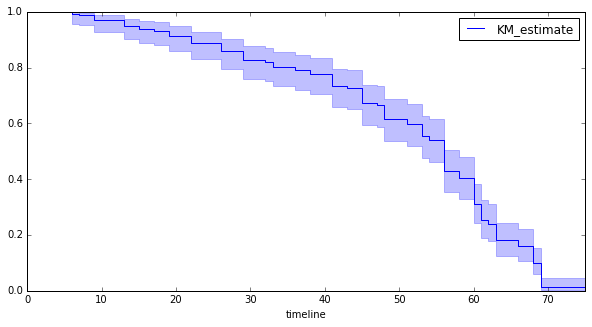

In [8]:
#After calling the fit method, we have access to new properties like survival_function_ and methods like plot(). 
#The latter is a wrapper around Pandas internal plotting library.
kmf.survival_function_
kmf.median_
kmf.plot();

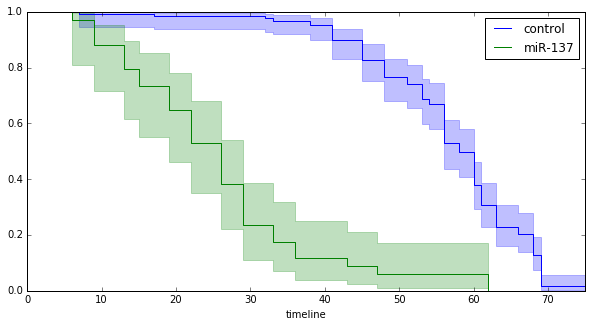

In [9]:
#Multiple Groups
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='miR-137')
kmf.plot(ax=ax);

In [10]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0.0,0.0,0.0,163.0,163.0
6.0,1.0,1.0,0.0,0.0,163.0
7.0,2.0,1.0,1.0,0.0,162.0
9.0,3.0,3.0,0.0,0.0,160.0
13.0,3.0,3.0,0.0,0.0,157.0


In [11]:
#While the above KaplanMeierFitter and NelsonAalenFitter are useful, they only give us an “average” view of the population. 
#Often we have specific data at the individual level, either continuous or categorical, that we would like to use. 
#For this, we turn to survival regression, specifically AalenAdditiveFitter or CoxPHFitter.

In [12]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()
regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


In [13]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'T', event_col='E')
cf.print_summary()

n=200, number of events=189

          coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95    
var1 2.083e-01  1.232e+00 6.992e-02 2.980e+00 2.886e-03   7.126e-02   3.454e-01  **
var2 4.607e-02  1.047e+00 7.506e-02 6.139e-01 5.393e-01  -1.011e-01   1.932e-01    
var3 2.110e-01  1.235e+00 7.316e-02 2.884e+00 3.931e-03   6.754e-02   3.544e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580


In [14]:
#After fitting, you’ll have access to properties like cumulative_hazards_ and 
#methods like plot, predict_cumulative_hazards, and predict_survival_function. 
#The latter two methods require an additional argument of individual covariates:

/Users/bwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


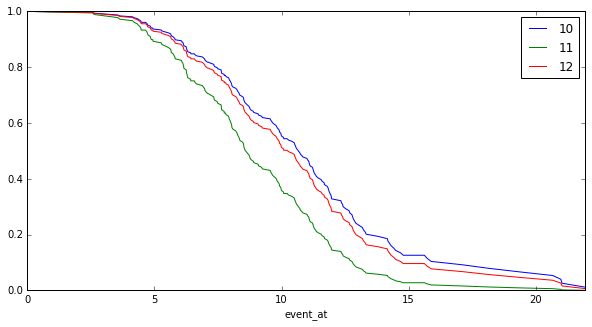

In [15]:
x = regression_dataset[regression_dataset.columns - ['E','T']]
cf.predict_survival_function(x.ix[10:12]).plot();

In [28]:
#For an experiment, using a canonical dataset called "Worcester Heart Attack Study (100 Patients)"
#https://www.umass.edu/statdata/statdata/stat-survival.html
#LENFOL: length of follow-up (days)
#FSTAT: loss to follow-up=0, death=1
#GENDER: males=0, females=1

In [17]:
df = pd.read_csv('whas100.csv')

In [18]:
df.head()

,id,admitdate,foldate,los,lenfol,fstat,age,gender,bmi
0,1,3/13/95,3/19/95,4,6,1,65,0,31.38134
1,2,1/14/95,1/23/96,5,374,1,88,1,22.65790
2,3,2/17/95,10/4/01,5,2421,1,77,0,27.87892
3,4,4/7/95,7/14/95,9,98,1,81,1,21.47878
4,5,2/9/95,5/29/98,4,1205,1,78,0,30.70601


In [19]:
kmf = KaplanMeierFitter()

In [20]:
T = df['lenfol']
C = df['fstat']

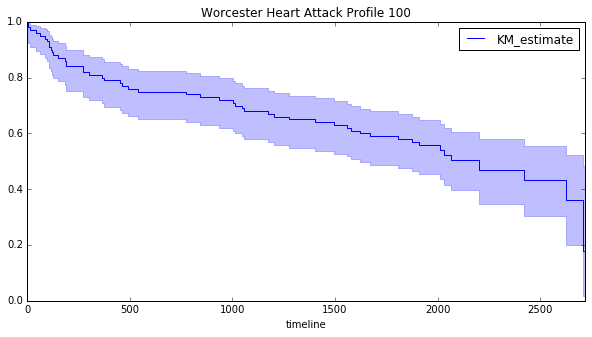

In [21]:
#kmf.fit(observed_lifetimes, event_observed=C)
kmf.fit(T, event_observed=C)
kmf.plot(title = 'Worcester Heart Attack Profile 100');

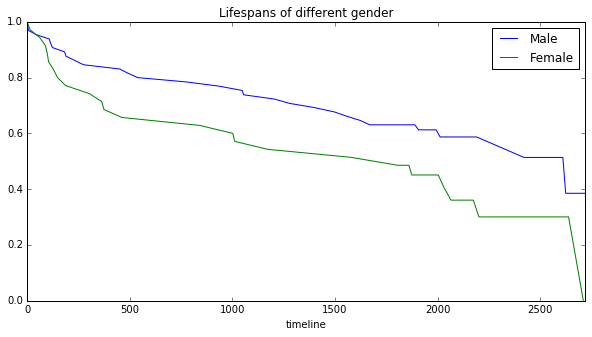

In [22]:
#male
f = df.gender==0
T = df[f]['lenfol']
C = df[f]['fstat']
#female
f2 = df.gender==1
T2 = df[f2]['lenfol']
C2 = df[f2]['fstat']

ax = plt.subplot(111)

kmf.fit(T, event_observed=C, label=['Male'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['Female'])
kmf.survival_function_.plot(ax=ax)

plt.title('Lifespans of different gender')

kmf2 = plt.gcf()

#In the graph of the KM curve stratified by gender, 
#it means that females have a worse survival experience compared with male.

In [12]:
#For listings data, they should be right-censored only. 
#That means for some listings we don’t know when they became pending, but we do know at least how many days they were listed.